# TABLE 2
Code to generate table 2

## Reqs

To run this notebook you have to download / get following files in addition to the files already present in the repository :
- `data/clinvar/clinvar_mutation_context.csv` available from Zenodo
- `data/cosmic/cosmic_mutation_context.csv` available from Zenodo
- `data/somamutdb/somamutdb_mutation_context.csv` available from Zenodo
- `hg38/kmer_counts_3N.csv` available from github and Zenodo
- `hg38/kmer_counts_5N.csv` available from github and Zenodo

In [48]:
GENERATE_RESULTS = True

import polars as pl
from scipy import stats
import matplotlib
from pathlib import Path
from viper import Viper
from utils import load_data, utils
from utils.utils import get_table_of_corr, print_markdown

fontdict = {"size": 14, "family": "sans-serif"}
matplotlib.rc("font", **fontdict)

PROJECT_DIR = Path().absolute().parent
VIPER = Viper()

In [49]:
datas = pl.concat(
    [
        pl.read_csv(
            PROJECT_DIR / "data" / db / f"{db}_mutation_context.csv",
            separator=",",
            schema_overrides={"chromosome": pl.Utf8},
        ).with_columns(
            pl.col("context").str.slice(4, 3).alias("3N"),
            pl.col("context").str.slice(3, 5).alias("5N"),
            pl.lit(db).alias("db"),
        )
        for db in ["cosmic", "clinvar", "somamutdb"]
    ],
    how="diagonal_relaxed",
).filter(~pl.col("context").str.contains("N"))

In [50]:
kmer3 = load_data.get_kmer_df(PROJECT_DIR / "hg38", 3)["context", "frequencies"]
kmer5 = load_data.get_kmer_df(PROJECT_DIR / "hg38", 5)["context", "frequencies"]

In [51]:
TYPE_ORDER = [
    "silent",
    "missence",
    "nonsence",
    "intronic",
    "UTR",
    "splice_region",
    "intergenic",
]
DB_ORDER = ["cosmic", "somamutdb", "clinvar", "all"]


def run_table2(
    df, kmer, context_col, category_col="type", categories=TYPE_ORDER, db_order=DB_ORDER, stat_method = stats.pearsonr, prefix = None
):
    df_with_all = pl.concat(
        [df, df.with_columns(pl.lit("all").alias("db"))],
        how="diagonal_relaxed",
    )
    aggregated = utils.aggregate_data(
        df_with_all.group_by([category_col, context_col, "db"]).len(),
        kmer,
        on=[category_col, "db", "context"],
        over=[category_col, "db"],
        context_col=context_col,
    )
    table_of_corr = get_table_of_corr(
            aggregated,
            categories=("db", db_order),
            sub_categories=(category_col, categories),
            corr_method=stat_method,
        )
    print_markdown(
        table_of_corr
    )
    if GENERATE_RESULTS and prefix:
        output_path = PROJECT_DIR / "outputs" / "datasets"  /  f"{prefix}_{stat_method.__name__}.tsv"
        output_path.parent.mkdir(parents=True, exist_ok=True)
        table_of_corr.write_csv(output_path, separator="\t")
    return aggregated

def compute_partial_corr_table(aggregated, db_order=DB_ORDER, type_order=TYPE_ORDER, stat_method=stats.pearsonr, prefix=None):
    """Partial correlation between F and vip controlling for GC content of context."""
    agg_gc = aggregated.with_columns(
        pl.col("context")
        .map_elements(
            lambda ctx: sum(1 for c in ctx if c in "GC"), return_dtype=pl.Int32
        )
        .alias("gc_count")
    )
    rows = []
    for db in db_order:
        for t in type_order:
            subset = agg_gc.filter((pl.col("db") == db) & (pl.col("type") == t))
            if len(subset) < 4:
                continue
            r, p = utils.partial_correlation(
                subset, "F", "vip", "gc_count", stat_method=stat_method
            )
            rows.append({"db": db, "type": t, "partial_r": r, "p_value": p})

    sort_key = {t: i for i, t in enumerate(type_order)}
    result = (
        pl.DataFrame(rows)
        .pivot(values="partial_r", index="type", on="db", aggregate_function=None)
        .with_columns(pl.col("type").replace_strict(sort_key).alias("_sort"))
        .sort("_sort")
        .drop("_sort")
        .select(["type"] + [db for db in db_order if db in pl.DataFrame(rows)["db"].unique()])
    )

    if GENERATE_RESULTS and prefix:
        output_path = PROJECT_DIR / "outputs" / "datasets" / f"{prefix}_corrected_{stat_method.__name__}.tsv"
        output_path.parent.mkdir(parents=True, exist_ok=True)
        result.write_csv(output_path, separator="\t")

    return result


In [52]:
# --- Trinucleotide context (3N) ---
stat_methods = [stats.pearsonr, stats.spearmanr]
for stat_method in stat_methods:
    print(f"### {stat_method.__name__} correlation (3N): F ~ vip")
    agg3 = run_table2(datas, kmer3, "3N", prefix="3N", stat_method=stat_method)
    print("### Partial correlation (3N): F ~ vip | GC content")
    print_markdown(compute_partial_corr_table(agg3, prefix="3N", stat_method=stat_method))

### pearsonr correlation (3N): F ~ vip
| type          |   cosmic |   somamutdb |   clinvar |   all |
|---------------|----------|-------------|-----------|-------|
| silent        |    -0.85 |       -0.87 |     -0.86 | -0.86 |
| missence      |    -0.77 |       -0.76 |     -0.72 | -0.76 |
| nonsence      |    -0.7  |       -0.63 |     -0.61 | -0.69 |
| intronic      |    -0.67 |       -0.71 |     -0.74 | -0.69 |
| UTR           |    -0.75 |       -0.75 |     -0.75 | -0.76 |
| splice_region |    -0.61 |       -0.68 |     -0.64 | -0.64 |
| intergenic    |    -0.72 |       -0.72 |     -0.8  | -0.72 |
### Partial correlation (3N): F ~ vip | GC content
| type          |   cosmic |   somamutdb |   clinvar |   all |
|---------------|----------|-------------|-----------|-------|
| silent        |    -0.7  |       -0.74 |     -0.72 | -0.72 |
| missence      |    -0.52 |       -0.52 |     -0.45 | -0.52 |
| nonsence      |    -0.55 |       -0.5  |     -0.45 | -0.54 |
| intronic      |    -0.53 |

In [53]:
# --- Pentanucleotide context (5N) ---
stat_methods = [stats.pearsonr, stats.spearmanr]
for stat_method in stat_methods:
    print(f"### {stat_method.__name__} correlation (5N): F ~ vip")
    agg5 = run_table2(datas, kmer5, "5N", prefix="5N", stat_method=stat_method)
    print("### Partial correlation (5N): F ~ vip | GC content")
    print_markdown(compute_partial_corr_table(agg5, prefix="5N", stat_method=stat_method))

### pearsonr correlation (5N): F ~ vip
| type          |   cosmic |   somamutdb |   clinvar |   all |
|---------------|----------|-------------|-----------|-------|
| silent        |    -0.77 |       -0.79 |     -0.77 | -0.78 |
| missence      |    -0.73 |       -0.76 |     -0.71 | -0.73 |
| nonsence      |    -0.29 |       -0.46 |     -0.29 | -0.32 |
| intronic      |    -0.59 |       -0.63 |     -0.69 | -0.62 |
| UTR           |    -0.7  |       -0.7  |     -0.75 | -0.71 |
| splice_region |    -0.47 |       -0.52 |     -0.45 | -0.47 |
| intergenic    |    -0.66 |       -0.61 |     -0.78 | -0.63 |
### Partial correlation (5N): F ~ vip | GC content
| type          |   cosmic |   somamutdb |   clinvar |   all |
|---------------|----------|-------------|-----------|-------|
| silent        |    -0.58 |       -0.61 |     -0.57 | -0.59 |
| missence      |    -0.49 |       -0.53 |     -0.45 | -0.49 |
| nonsence      |    -0.38 |       -0.42 |     -0.32 | -0.39 |
| intronic      |    -0.51 |

In [54]:
agg3

type,db,context,count,vip,freq,frequencies,F
str,str,str,u32,f64,f64,f64,f64
"""intronic""","""somamutdb""","""GCT""",75421,7.5995,0.030517,0.013846,0.790281
null,"""somamutdb""","""ACA""",213,7.67655,0.039873,0.020188,0.680603
null,"""clinvar""","""GCC""",46,7.6176,0.055288,0.011743,1.549288
"""intronic""","""cosmic""","""CTT""",273461,7.8247,0.040069,0.020199,0.684984
"""intergenic""","""all""","""ACG""",397974,7.3045,0.067213,0.002582,3.2594
…,…,…,…,…,…,…,…
"""silent""","""cosmic""","""GTC""",8751,7.7407,0.006143,0.00935,-0.420068
"""nonsence""","""somamutdb""","""ATC""",34,7.94295,0.003187,0.013302,-1.428894
"""UTR""","""clinvar""","""GCG""",3923,7.39705,0.056274,0.00241,3.150805


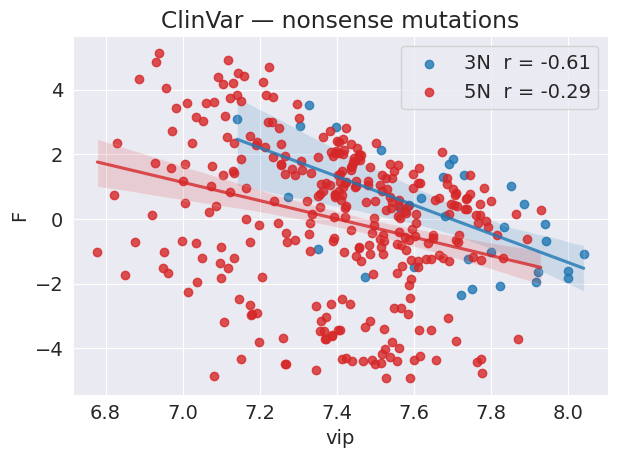

In [55]:
import seaborn as sbs
import matplotlib.pyplot as plt
from scipy import stats

fig, ax = plt.subplots()

for kmer, data, color in [
    ("3N", agg3.filter(pl.col("db") == "clinvar", pl.col("type") == "nonsence"), "#1f77b4"),
    ("5N", agg5.filter(pl.col("db") == "clinvar", pl.col("type") == "nonsence"), "#d62728"),
]:
    x = data["vip"].to_numpy()
    y = data["F"].to_numpy()
    r, p = stats.pearsonr(x, y)
    sbs.regplot(
        data.to_pandas(), x="vip", y="F",
        color=color, label=f"{kmer}  r = {r:.2f}",
        scatter_kws={"alpha": 0.8},
        line_kws={"alpha": 0.8},
        ax=ax,
    )

ax.legend()
ax.set_title("ClinVar — nonsense mutations")
plt.tight_layout()
plt.show()